Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
%matplotlib inline
warnings.filterwarnings('ignore')

*Загрузим данные*

In [2]:
pd.options.display.max_columns = None
data = pd.read_csv('/datasets/autos.csv')

*Проведем разведочный анализ данных*

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


*Видим что у нас 6 категориальных признаков и 3 признаков временных, 6 числовых признаков и 1 целевая переменная*

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


*По предварительному осмотру мы видим:*
  * *Признак NumberOfPictures полностью нулевой - удалим его.*
  * *Признак Price имеет нулевые значения - отделим их и будем использовать как тестовый для предсказаний.*
  * *Признак RegistrationYear имеет минимальное значение 1000, максимальное - 9999 и отклонение в 90 лет - обработаем эти данные дальше*
  * *Признак Power имеет как нулевые, так и нереально больше значения - обработаем дальше*
  * *Признак RegistrationMonth имеет отсутствие значения - 0 , решим дальше как с этим быть*
  * *Признак PostalCode - данные могут быть важны, попробуем отрезать два первых значения и использовать только их*
  * *Признаки DateCrawled и DateCreated - происходят в одну дату, удалим DateCreated*

***

*Посмотрим на пропуски в данных*

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

***

#### *Начнем предобработку данных*

*Обработаем PostalCode, отбросим три последних числа, как слишком детализирующие локацию - первые два числа могут идентифицировать регион*

In [7]:
data['PostalCode'] = data['PostalCode'].apply(lambda x: x // 1000)

*Удалим NumberOfPictures и DateCreated*

In [8]:
data.drop('NumberOfPictures', axis=1, inplace=True)
data.drop('DateCreated', axis=1, inplace=True)

*Обработаем наименование модели и тип кузова по обределенному бренду - заменим NaN на other*

In [9]:
data['Model'] = data['Model'].fillna('other')
data['VehicleType'] = data['VehicleType'].fillna('other')

*Обработаем Gearbox - заменим на самую популярную - механику*

In [10]:
data.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [11]:
data['Gearbox'] = data['Gearbox'].fillna('manual')

*Далее попробуем заменить значения пропусков в признаке FuelType*

In [12]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

*Заменим значения на метки (пропуски заменим на бензиновые двигатели - самые популярные):*
 - *petrol и gasoline - это бензин (5)*
 - *lpg и cng - это газ (4)*
 - *hybrid (3)*
 - *other (2)*
 - *electric (1)*

In [13]:
#Пропуски на бензин
data['FuelType'] = data['FuelType'].fillna('petrol')

In [14]:
FuelType_dict = {'petrol' : 5, 
                 'gasoline' : 5, 
                 'lpg' : 4, 
                 'cng' : 4, 
                 'hybrid' : 3, 
                 'other' : 2, 
                 'electric' : 1
                }
data['FuelType'] = data['FuelType'].map(FuelType_dict)

*Теперь заполним признак NotRepaired. Так как определить была ли машина в ремонте или нет у нас нет возможности, то заполним данный пропуск вероятностным методом, в зависимости от частоты встречаемости того или иного значения в признаке*

In [15]:
#Частота возникновения класса
probab_NotRepaired = data.NotRepaired.value_counts(normalize=True).values

In [16]:
def probab_fillna(value):
    if value!=value:
        return random.choices(('no', 'yes'), weights=probab_NotRepaired)[0]
    else:
        return value

In [17]:
data['NotRepaired'] = data['NotRepaired'].apply(probab_fillna)

In [18]:
NotRepaired_dict = {'no' : 0, 
                    'yes' : 1}
data['NotRepaired'] = data['NotRepaired'].map(NotRepaired_dict)

*Теперь закодируем признак Gearbox*

In [19]:
Gearbox_dict = {'manual' : 0, 
                'auto' : 1}
data['Gearbox'] = data['Gearbox'].map(Gearbox_dict)

*Далее закодируем Brand средней ценой бренда*

In [20]:
Brand_dict = {}

for i, j in zip(data.groupby('Brand')['Price'].mean().index, 
                data.groupby('Brand')['Price'].mean().values):
    Brand_dict[i] = j

data['Brand'] = round(data['Brand'].map(Brand_dict)).astype('int64')

*Аналогичным образом закодируем и Model*

In [21]:
Model_dict = {}

for i, j in zip(data.groupby('Model')['Price'].mean().index, 
                data.groupby('Model')['Price'].mean().values):
    Model_dict[i] = j

data['Model'] = round(data['Model'].map(Model_dict)).astype('int64')

*У нас остался один категориальный признак, который не закодирован - VehicleType. Закодируем его количеством встреячаемости, деленным целочисленно на 1000*

In [22]:
VehicleType_dict = {}

for i, j in zip(data.groupby('VehicleType')['VehicleType'].count().index, 
                data.groupby('VehicleType')['VehicleType'].count().values):
    VehicleType_dict[i] = j

data['VehicleType'] = data['VehicleType'].map(VehicleType_dict) // 1000

***

*Займемся обработкой двух столбцов с датами*

In [23]:
data.DateCrawled = pd.to_datetime(data.DateCrawled)
data.LastSeen = pd.to_datetime(data.LastSeen)

#Добавим timedelta 
data['timedelta'] = (data.LastSeen - data.DateCrawled).dt.days

#разложим время на компоненты
data['DateCrawled_day'] = data.DateCrawled.dt.day
data['DateCrawled_month'] = data.DateCrawled.dt.month
data['DateCrawled_week'] = data.DateCrawled.dt.weekday+1

data['LastSeen_day'] = data.LastSeen.dt.day
data['LastSeen_month'] = data.LastSeen.dt.month
data['LastSeen_week'] = data.LastSeen.dt.weekday+1

#удалим лишние столбцы, которые отработаны
data = data.drop(['DateCrawled', 'LastSeen'], axis=1)

***

#### Теперь проанализируем числовые признаки на наличие аномалий

In [24]:
numeric_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def plot_numeric(data, numeric_columns):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(numeric_columns, axes.ravel()):
        ax.set_title(column)
        sns.distplot(data[column], ax=ax)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(numeric_columns, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(data[column], ax=ax)

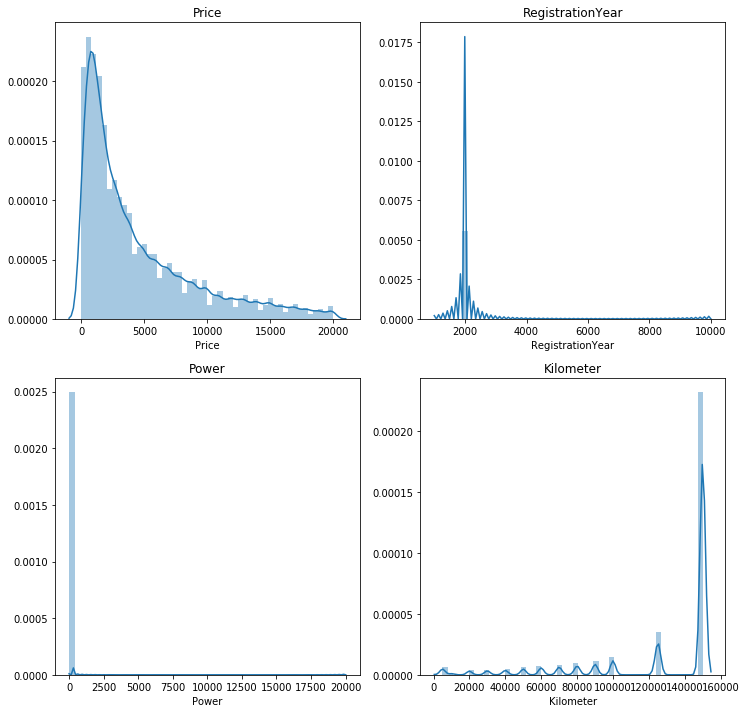

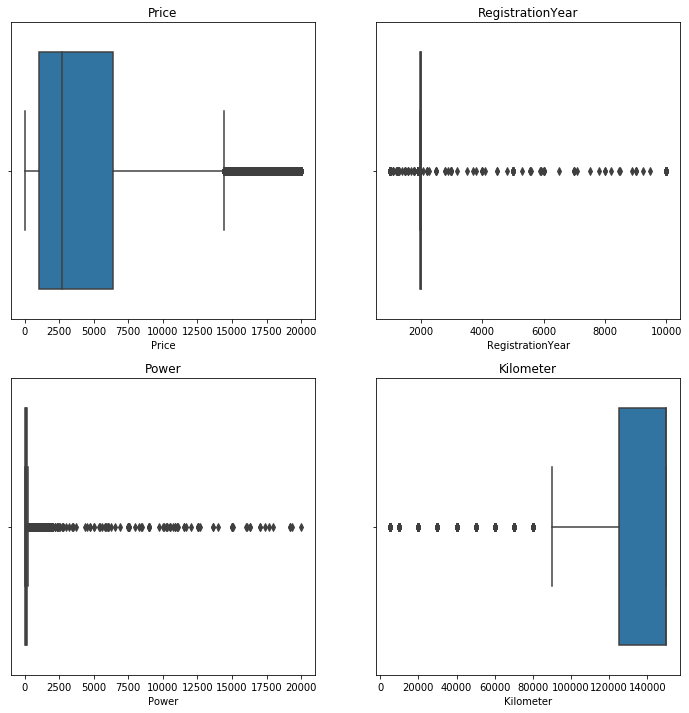

In [25]:
plot_numeric(data, numeric_columns)

*Видим явные проблемы в данных, а именно:*
 - *Нули в стоимости - это мы отделим от датасета и будем использовать как тестовые данные*
 - *Не корректное указание года выпуска модели - исправим медианным по модели*
 - *Не корректное указание мощности, есть огромные выбросы - заменим медианным*

#### *RegistrationYear*

*Определим, что машин младше 2019 годав данных быть не должно, так же как и машин старше 1960 года. Посмотрим сколько таких записей у нас*

In [26]:
print("Процент данных с ошибками по годам: {:.2%}".format(data
                                                          .query('RegistrationYear<1960 or RegistrationYear>2019')
                                                          .shape[0] / data.shape[0]))

Процент данных с ошибками по годам: 0.15%


In [27]:
#Удалим такие данные
data = data.loc[(data['RegistrationYear']>1960) & (data['RegistrationYear']<2020)]

In [28]:
#Проконтролируем количество записей
print("Размер датафрейма:", data.shape)

Размер датафрейма: (353654, 19)


***

#### *Power*

*Посмотрим, сколько у нас всего значений с нулевой мощностью*

In [29]:
print("Записей с нулевой мощностью:", data[data['Power']==0].shape[0])

Записей с нулевой мощностью: 39782


*Посчитаем среднюю мощность по модели, за исключением нулевых значений и 1% квантиля, заполним этими данными нулевую мощность. Обязательно учтем и аномально большую мощность - больше 99% квантиля*

In [30]:
power_lower_quantile = data[data['Power']!=0]['Power'].quantile(.01)
power_higher_quantile = data[data['Power']!=0]['Power'].quantile(.99)

Power_dict = {}

for i, j in zip(data.query('Power>=@power_lower_quantile and Power<@power_higher_quantile').groupby('Model')['Power'].mean().index, 
                data.query('Power>=@power_lower_quantile and Power<@power_higher_quantile').groupby('Model')['Power'].mean().values):
    Power_dict[i] = round(j).astype('int64')

data.loc[((data['Power']<power_lower_quantile) | (data['Power']>=power_higher_quantile)), 'Power'] = data['Model'].map(Power_dict)
data = data.dropna()

In [31]:
#Проконтролируем количество записей
print("Размер датафрейма:", data.shape)

Размер датафрейма: (353652, 19)


*Потеряли 2 записи - приемлемо - продолжаем*

***

#### *Price*

*По данному пункту особых преобразований нет. Предположим, что машины дешевле 200 - ошибочно указанная цена - занулим ее и будем использовать часть датасета с нулевыми значениями как тестовый*

In [32]:
data.loc[data['Price']<=200, 'Price'] = 0

***

*Посмотрим на получившиеся распределения*

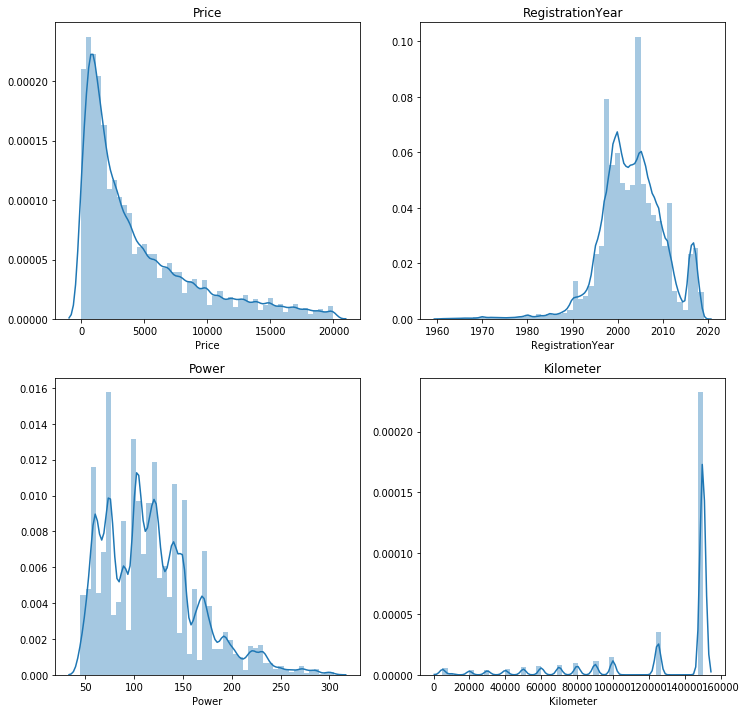

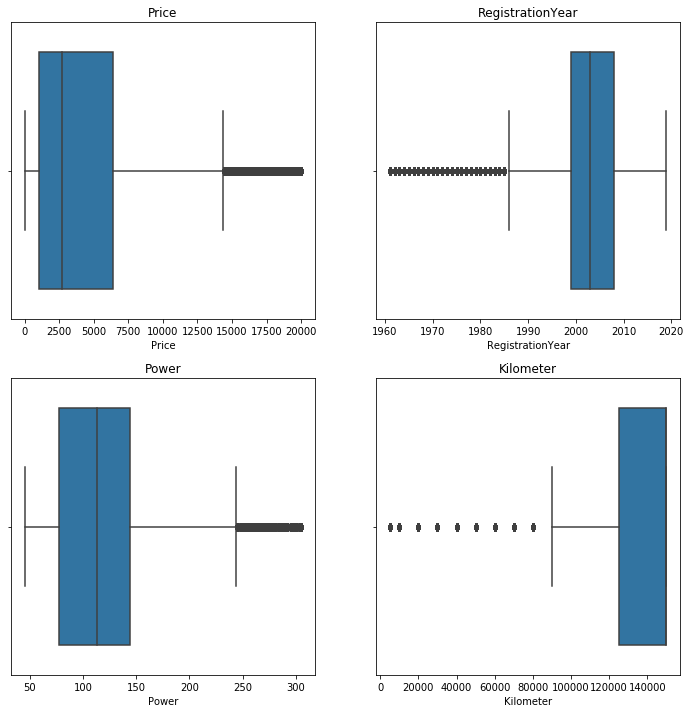

In [33]:
plot_numeric(data, numeric_columns)

*Отлично, распределения стали больше похожи на нормальные - двигаемся дальше.*

***

### Feature engineering

*При конструировании новых признаков, в данном датасете было бы хорошо попробовать сконструировать следующие:*
 - *Медианный год по модели*
 - *Средний год по модели*
c
 - *Среднее отклонение года по модели*
 - *Медианная мощность по модели*
 - *Средняя мощность по модели*
 - *Минимальная/максимальная мощность по модели*
 - *Среднее отклонение мощности по модели*

 *Можно сконструировать и больше признаков, но тогда модели будут долго обучаться*

In [34]:
def features(df):
    for c in ['RegistrationYear','Power']:
        d = {}
        d['mean_'+c] = df.groupby(['Model'])[c].mean()
        d['median_'+c] = df.groupby(['Model'])[c].median()
        d['max_'+c] = df.groupby(['Model'])[c].max()
        d['min_'+c] = df.groupby(['Model'])[c].min()
        d['std_'+c] = df.groupby(['Model'])[c].std()
        d['range_'+c] = d['max_'+c] - d['min_'+c]
        for v in d:
            df[v] = df['Model'].map(d[v].to_dict())
    return df

In [35]:
final_data = features(data)

*Посмотрим на финальный датафрейм*

In [36]:
print("Размер суммарного датафрейма:", final_data.shape)
final_data.head()

Размер суммарного датафрейма: (353652, 31)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,timedelta,DateCrawled_day,DateCrawled_month,DateCrawled_week,LastSeen_day,LastSeen_month,LastSeen_week,mean_RegistrationYear,median_RegistrationYear,max_RegistrationYear,min_RegistrationYear,std_RegistrationYear,range_RegistrationYear,mean_Power,median_Power,max_Power,min_Power,std_Power,range_Power
0,480,40,1993,0,104.0,4154,150000,0,5,4381,0,70,13,24,3,4,7,4,4,2002.662969,2001.0,2018,1970,7.683242,48,103.771182,101.0,305.0,45.0,35.101025,260.0
1,18300,16,2011,0,190.0,3751,125000,5,5,6240,1,66,13,24,3,4,7,4,4,2000.571166,2001.0,2019,1961,10.117078,58,122.273124,122.0,305.0,45.0,44.869632,260.0
2,9800,11,2004,1,163.0,6383,125000,8,5,7065,0,90,21,14,3,1,5,4,2,2004.085826,2004.0,2018,1990,4.622513,28,157.258778,150.0,287.0,70.0,36.096108,217.0
3,1500,79,2001,0,75.0,4154,150000,6,5,4381,0,91,0,17,3,4,17,3,4,2002.662969,2001.0,2018,1970,7.683242,48,103.771182,101.0,305.0,45.0,35.101025,260.0
4,3600,79,2008,0,69.0,4184,90000,7,5,5910,0,60,5,31,3,4,6,4,3,2006.817788,2006.0,2018,1991,4.190276,27,79.189423,75.0,180.0,47.0,19.038143,133.0


*Разделим данные на тренировочные и на тестовые*

In [37]:
train_df = final_data[final_data['Price']!=0]
test_df = final_data[final_data['Price']==0]
print('Размер тренировочного датасета:', train_df.shape)
print('Размер тестового датасета:', test_df.shape)

Размер тренировочного датасета: (334461, 31)
Размер тестового датасета: (19191, 31)


In [38]:
train_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,timedelta,DateCrawled_day,DateCrawled_month,DateCrawled_week,LastSeen_day,LastSeen_month,LastSeen_week,mean_RegistrationYear,median_RegistrationYear,max_RegistrationYear,min_RegistrationYear,std_RegistrationYear,range_RegistrationYear,mean_Power,median_Power,max_Power,min_Power,std_Power,range_Power
0,480,40,1993,0,104.0,4154,150000,0,5,4381,0,70,13,24,3,4,7,4,4,2002.662969,2001.0,2018,1970,7.683242,48,103.771182,101.0,305.0,45.0,35.101025,260.0
1,18300,16,2011,0,190.0,3751,125000,5,5,6240,1,66,13,24,3,4,7,4,4,2000.571166,2001.0,2019,1961,10.117078,58,122.273124,122.0,305.0,45.0,44.869632,260.0
2,9800,11,2004,1,163.0,6383,125000,8,5,7065,0,90,21,14,3,1,5,4,2,2004.085826,2004.0,2018,1990,4.622513,28,157.258778,150.0,287.0,70.0,36.096108,217.0
3,1500,79,2001,0,75.0,4154,150000,6,5,4381,0,91,0,17,3,4,17,3,4,2002.662969,2001.0,2018,1970,7.683242,48,103.771182,101.0,305.0,45.0,35.101025,260.0
4,3600,79,2008,0,69.0,4184,90000,7,5,5910,0,60,5,31,3,4,6,4,3,2006.817788,2006.0,2018,1991,4.190276,27,79.189423,75.0,180.0,47.0,19.038143,133.0


***

*Посмотрим на тепловую карту получившихся признаков*

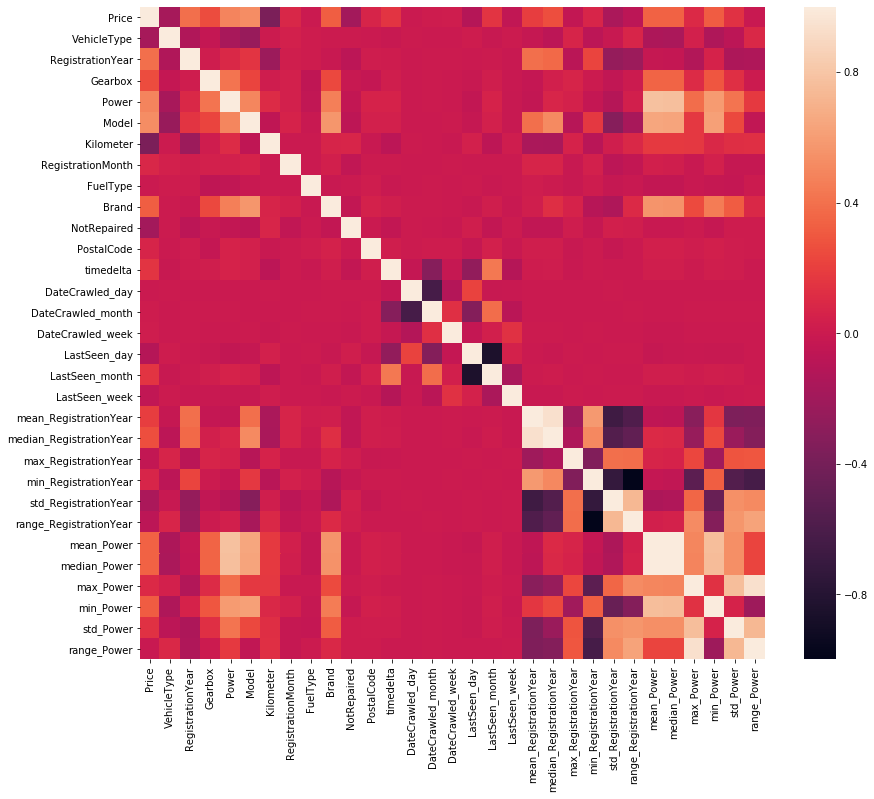

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
sns.heatmap(train_df.corr());

*Видим, что примерно половина признаков коррелирует с целевой переменной, а так же есть ряд признаков, которые сильно коррелируют между собой.*

*Восспользуемся отбором признаков, используя f_regression(так как в наших данных есть отрицательные значения, Хи-квадрат не работает), отберем половину из существующих признаков(15)*

In [149]:
X = train_df.drop('Price', axis=1)
y = train_df['Price']
X_test = test_df.drop('Price', axis=1)

In [150]:
select = SelectKBest(f_regression, k=15)
select.fit(X, y)
X = select.transform(X)
X_test = select.transform(X_test)

***

# 2. Обучение моделей

*Разделим тренировочный датасет на обучающий и валидационный*

In [97]:
x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=42)



*Первой модель обучим - CatBoost*

In [152]:
'''
Нереально долго работает, описал выше, с радостью бы выполнил этот пункт - это очень не сложно, НО увы...
Так бы мог сделать и для остальных моделей:
дальше бы я получил лучшие параметры из гридсёрча, добавил бы необходимые параметры в словарь и обучил
модель на этих параметрах.
Поверь, я умею это делать, но жупитер хаб не позволяет это, и домашняя машина тоже без ГПУ - медленная
'''
#param_grid_cb = {'learning_rate': [0.08, 0.1], 
#                 'depth': [8, 6]}

#model = cb.CatBoostRegressor(silent=True)
#grid = GridSearchCV(model, param_grid_cb)
#grid.fit(X, y)

'\nНереально долго работает, описал выше, с радостью бы выполнил этот пункт - это очень не сложно, НО увы...\nТак бы мог сделать и для остальных моделей:\nдальше бы я получил лучшие параметры из гридсёрча, добавил бы необходимые параметры в словарь и обучил\nмодель на этих параметрах.\nПоверь, я умею это делать, но жупитер хаб не позволяет это, и домашняя машина тоже без ГПУ - медленная\n'

In [154]:
train_cb = cb.Pool(x1, y1)
valid_cb = cb.Pool(x2, y2)
test_cb = cb.Pool(X_test)
models_timings = {}

param_grid_cb = {'loss_function': 'RMSE', 
                 'learning_rate': 0.1, 
                 'subsample' : 0.8,
                 'depth': 8}

#Начнем считать время
start_time = time.time()

model_cb = cb.train(params=param_cb, 
              dtrain=train_cb, 
              eval_set=valid_cb, 
              early_stopping_rounds=50, 
              verbose_eval=50, 
              plot=True)

#Закончим считать время
time_train_catboost = time.time() - start_time
models_timings['CatBoost'] = time_train_catboost
print("Время обучения CatBoost:", time_train_catboost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4294.1054368	test: 4245.2248840	best: 4245.2248840 (0)	total: 299ms	remaining: 4m 58s
50:	learn: 1976.8928715	test: 1966.0804383	best: 1966.0804383 (50)	total: 9.96s	remaining: 3m 5s
100:	learn: 1850.9235753	test: 1850.8928079	best: 1850.8928079 (100)	total: 19.5s	remaining: 2m 53s
150:	learn: 1798.6121945	test: 1802.7132086	best: 1802.7132086 (150)	total: 29.1s	remaining: 2m 43s
200:	learn: 1767.7772615	test: 1775.6584964	best: 1775.6584964 (200)	total: 38.8s	remaining: 2m 34s
250:	learn: 1745.5952781	test: 1757.8714099	best: 1757.8714099 (250)	total: 48.5s	remaining: 2m 24s
300:	learn: 1728.2806767	test: 1744.3553224	best: 1744.3553224 (300)	total: 58s	remaining: 2m 14s
350:	learn: 1714.1885782	test: 1734.4967303	best: 1734.4967303 (350)	total: 1m 7s	remaining: 2m 5s
400:	learn: 1701.7070025	test: 1724.5737524	best: 1724.5737524 (400)	total: 1m 17s	remaining: 1m 55s
450:	learn: 1690.2170534	test: 1716.2512811	best: 1716.2512811 (450)	total: 1m 26s	remaining: 1m 45s
500:	lea

In [156]:
predict_catboost = model_cb.predict(test_cb)

***

*Теперь обучим XGBoost*

In [157]:
train_xgb = xgb.DMatrix(x1, y1)
valid_xgb = xgb.DMatrix(x2, y2)

param_xgb = {'objective': 'reg:squarederror', 
             'learning_rate': 0.1, 
             'subsample' : 0.8, 
             'max_depth': 8, 
             'eval_metric': 'rmse'}

#Начнем считать время
start_time = time.time()

model_xgb = xgb.train(params=param_xgb, 
                      dtrain=train_xgb,
                      num_boost_round=1000,
                      evals=[(valid_xgb, 'eval'), (train_xgb, 'train')],
                      early_stopping_rounds=50,
                      verbose_eval=50)

time_train_xgboost = time.time() - start_time
models_timings['XGBoost'] = time_train_xgboost
print("Время обучения XGBoost:", time_train_xgboost)

[0]	eval-rmse:5861.71	train-rmse:5926.97
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 50 rounds.
[50]	eval-rmse:1697.03	train-rmse:1624.32
[100]	eval-rmse:1655.68	train-rmse:1544.8
[150]	eval-rmse:1633.41	train-rmse:1494.97
[200]	eval-rmse:1619.77	train-rmse:1458.06
[250]	eval-rmse:1611.6	train-rmse:1430.31
[300]	eval-rmse:1603.9	train-rmse:1403.72
[350]	eval-rmse:1598.43	train-rmse:1380.73
[400]	eval-rmse:1596.26	train-rmse:1362.86
[450]	eval-rmse:1594.15	train-rmse:1345.6
[500]	eval-rmse:1592.81	train-rmse:1330.34
[550]	eval-rmse:1591.37	train-rmse:1315.34
[600]	eval-rmse:1590.97	train-rmse:1302.92
[650]	eval-rmse:1590.12	train-rmse:1290.65
[700]	eval-rmse:1588.9	train-rmse:1278.75
[750]	eval-rmse:1588.31	train-rmse:1269.34
[800]	eval-rmse:1588.36	train-rmse:1260.62
[850]	eval-rmse:1588.14	train-rmse:1250.93
[900]	eval-rmse:1588.3	train-rmse:1242.99
[950]	eval-rmse:1588.52	train-rmse:1234.99
[999

In [161]:
test_xgb = xgb.DMatrix(X_test)
predict_xgboost = model_xgb.predict(test_xgb)

***

*И последней моделью обучим LightGBM*

In [163]:
train_lgb = lgb.Dataset(x1, y1)
valid_lgb = lgb.Dataset(x2, y2)

param_lgb = {'objective': 'regression', 
             'learning_rate': 0.1, 
             'subsample' : 0.8, 
             'max_depth': 8, 
             'metric': 'rmse'}

#Начнем считать время
start_time = time.time()

model_lgb = lgb.train(params=param_lgb, 
                      train_set=train_lgb,
                      num_boost_round=1000,
                      valid_sets=[valid_lgb, train_lgb], 
                      valid_names=['eval', 'train'], 
                      early_stopping_rounds=50, 
                      verbose_eval=50)

time_train_lightgb = time.time() - start_time
models_timings['LightGBM'] = time_train_lightgb
print("Время обучения LightGBM:", time_train_lightgb)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 1811.18	eval's rmse: 1819.25
[100]	train's rmse: 1725.77	eval's rmse: 1748.03
[150]	train's rmse: 1683.02	eval's rmse: 1716.61
[200]	train's rmse: 1652.39	eval's rmse: 1695.96
[250]	train's rmse: 1629.12	eval's rmse: 1680.72
[300]	train's rmse: 1610.92	eval's rmse: 1669.8
[350]	train's rmse: 1595.42	eval's rmse: 1661.18
[400]	train's rmse: 1582.68	eval's rmse: 1654.72
[450]	train's rmse: 1570.61	eval's rmse: 1648.89
[500]	train's rmse: 1558.82	eval's rmse: 1642.77
[550]	train's rmse: 1547.03	eval's rmse: 1636.87
[600]	train's rmse: 1538.36	eval's rmse: 1633.13
[650]	train's rmse: 1528.8	eval's rmse: 1629.4
[700]	train's rmse: 1519.7	eval's rmse: 1626
[750]	train's rmse: 1511.95	eval's rmse: 1622.61
[800]	train's rmse: 1503.82	eval's rmse: 1619.23
[850]	train's rmse: 1496.1	eval's rmse: 1616.61
[900]	train's rmse: 1489.42	eval's rmse: 1614.25
[950]	train's rmse: 1484.03	eval's rmse: 1612.73
[1000]	train's rm

In [164]:
predict_lgb = model_lgb.predict(X_test)

***

In [173]:
model_lr = LinearRegression()

#Начнем считать время
start_time = time.time()
model_lr.fit(x1, y1)

time_train_lr = time.time() - start_time
models_timings['LinearRegression'] = time_train_lr

predict_lr = pd.DataFrame(model_lr.predict(x2))
score_lr = mean_squared_error(y2, predict_lr) ** 0.5

print("RMSE Линейной регрессии:", score_lr)
print("Время обучения LinearRegression:", time_train_lr)

RMSE Линейной регрессии: 2862.84697864756
Время обучения LinearRegression: 0.14910387992858887


***

*Подготовим данные для анализа*

In [179]:
predict_df = pd.DataFrame(data=[pd.Series(predict_catboost), pd.Series(predict_xgboost), pd.Series(predict_lgb)]).T
predict_df.columns = ['CatBoost', 'XGBoost', 'LightGBM']

In [180]:
best_scores_models = pd.DataFrame(data=[model_cb.best_score_['validation']['RMSE'], 
                                        1590.16, 
                                        model_lgb.best_score['eval']['rmse'], 
                                        score_lr])
time_models = pd.DataFrame(pd.Series(models_timings)).reset_index()
time_models.columns = ['model', 'worktime']
time_models['best_scores'] = best_scores_models
del best_scores_models

*Мы завершили обучение моделей - дальше мы проанализируем каждую из них*

***

# 3. Анализ моделей

*Для начала давайте оценим скорость работы каждой модели и ошибку на валидации*

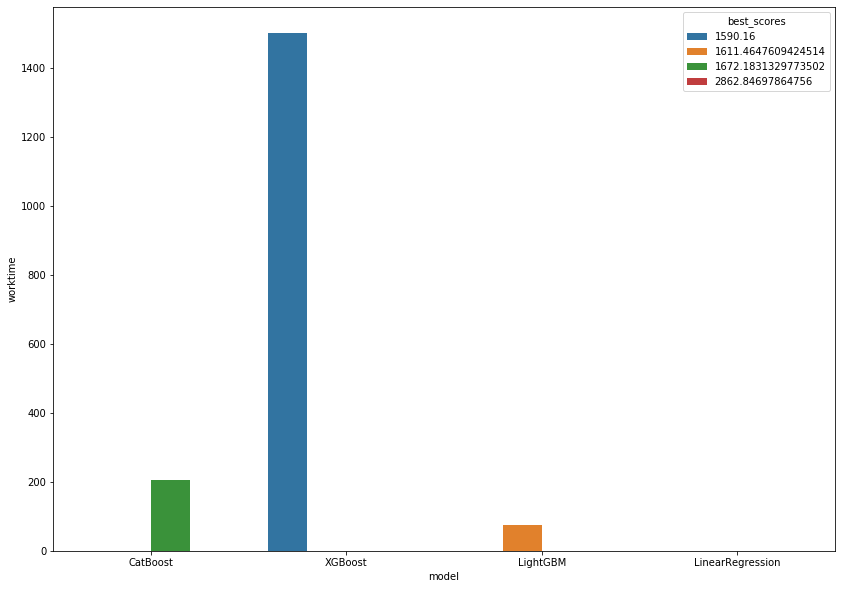

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.barplot(x='model', y='worktime', hue='best_scores', data=time_models);

In [182]:
time_models

,model,worktime,best_scores
0,CatBoost,205.242284,1672.183133
1,XGBoost,1501.242884,1590.160000
2,LightGBM,75.913953,1611.464761
3,LinearRegression,0.149104,2862.846979


*По данному графику/таблице, мы можем сделать выводы:*
 - *XGBoost на наших данных предсказал самую маленькую ошибку, но время обучения модели - очень долгое*
 - *CatBoost показал худший результат по ошибке, но время обучения на порядок выше, чем у XGBoost*
 - *LightGBM на этих данных показал себя лучше предыдущих, так как точность соизмеримая с XGBoost, а скорочть обучения в 2.5 раза выше чем у CatBoost*
 - *Линейная регрессия очень быстро обучается, но ошибку выдает тоже большую*

*Посмотрим на распределения предсказаний и обучающего набора*

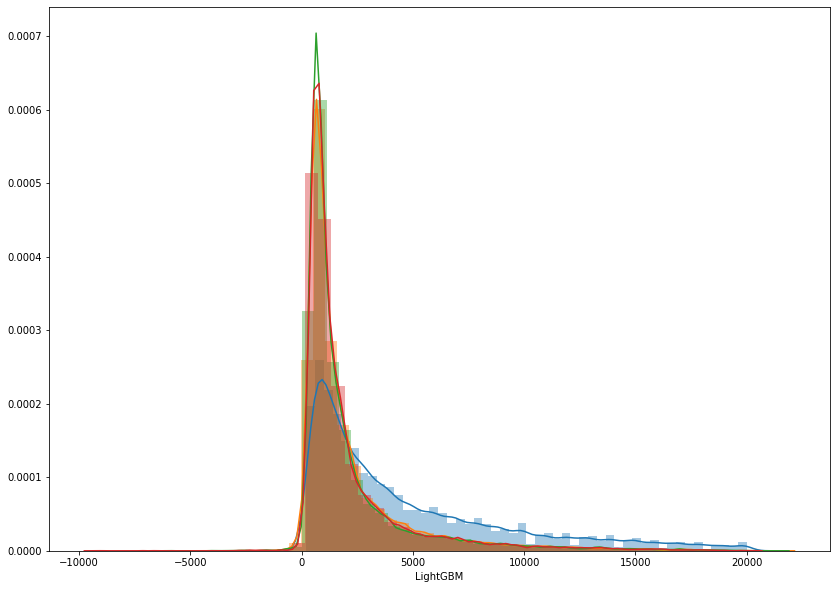

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.distplot(train_df['Price'])
sns.distplot(predict_df['CatBoost'])
sns.distplot(predict_df['XGBoost'])
sns.distplot(predict_df['LightGBM']);

*Видим, что распределения трех различных моделей слились, практически в одну - можем пердположить что распределение предсказаний идентичны, а так же форма распределений повторяет распределение из обучающего набора (полные данные)*